## 라벨링
 1. roboflow 데이터셋 라벨링 하기

    roboflow 데이터셋은 dataset 정보에 가보면 transform이 되어 나오는 경우가 있다. 따라서 해당 데이터셋에 대한 좌표정보가 올바른지를 체킹해야만한다

 1. 라벨 정보 바꾸기
전부 1로 변경

 1. 확인 및 시각화


### 파일 체크

In [2]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from torchvision.io import read_image
from pathlib import Path
from torchvision.utils import make_grid
from torchvision.utils import draw_bounding_boxes

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def read_boxes_from_file(file_path):
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces
            values = line.split(' ')  # Split line by space delimiter
            class_index = int(values[0])
            x, y, w, h = map(float, values[1:])
            idx, box = class_index, (x, y, w, h)
            boxes.append((idx,box))
    return boxes #  [(클래스 인덱스, 박스좌표), ....]

def get_xxyy(box, size):
    x_cen = int(box[0]*size[1])
    y_cen = int(box[1]*size[0])
    w = int(box[2]*size[1])
    h = int(box[3]*size[0])

    x_min = int(x_cen - (w / 2)) 
    y_min = int(y_cen - (h / 2)) 
    x_max = int(x_cen + (w / 2)) 
    y_max = int(y_cen + (h / 2)) 

    return x_min, y_min, x_max, y_max

root_dir='./datasets/box/relabeled_7/train/'
txt_list=glob.glob(root_dir+"labels/*.txt")
img_list=glob.glob(root_dir+"images/*.jpg")

In [50]:
#crack label: 1으로 변경하기 
#0번 3번이 crack이고 나머지는 아님
for file_path in txt_list:
    # Read the contents of the txt file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the class index in each line
    modified_lines = []
    for line in lines:
        data = line.split()
        if (data[0]=='3') or(data[0]=='4'):  # spalling은 crack 처리
            data[0] = '1'  # Change the class index to 1
        else: data[0] ='0'
        modified_line = ' '.join(data) + '\n'
        modified_lines.append(modified_line)
    
    # Write the updated contents back to the txt file
    with open(file_path, 'w') as file:
        file.writelines(modified_lines)

In [4]:
#non crack label: 0으로 변경하기 
from glob import glob

txt_list=glob("./datasets/box/relabeling/relabel/val/labels/*.txt")
for file_path in txt_list:
    # Read the contents of the txt file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the class index in each line
    modified_lines = []
    for line in lines:
        data = line.split()
        if (data[0]=='1'):  
            data[0] = '0'  
        else:
            raise Exception("확인해야함!",file_path)
        modified_line = ' '.join(data) + '\n'
        modified_lines.append(modified_line)
    
    # Write the updated contents back to the txt file
    with open(file_path, 'w') as file:
        file.writelines(modified_lines)

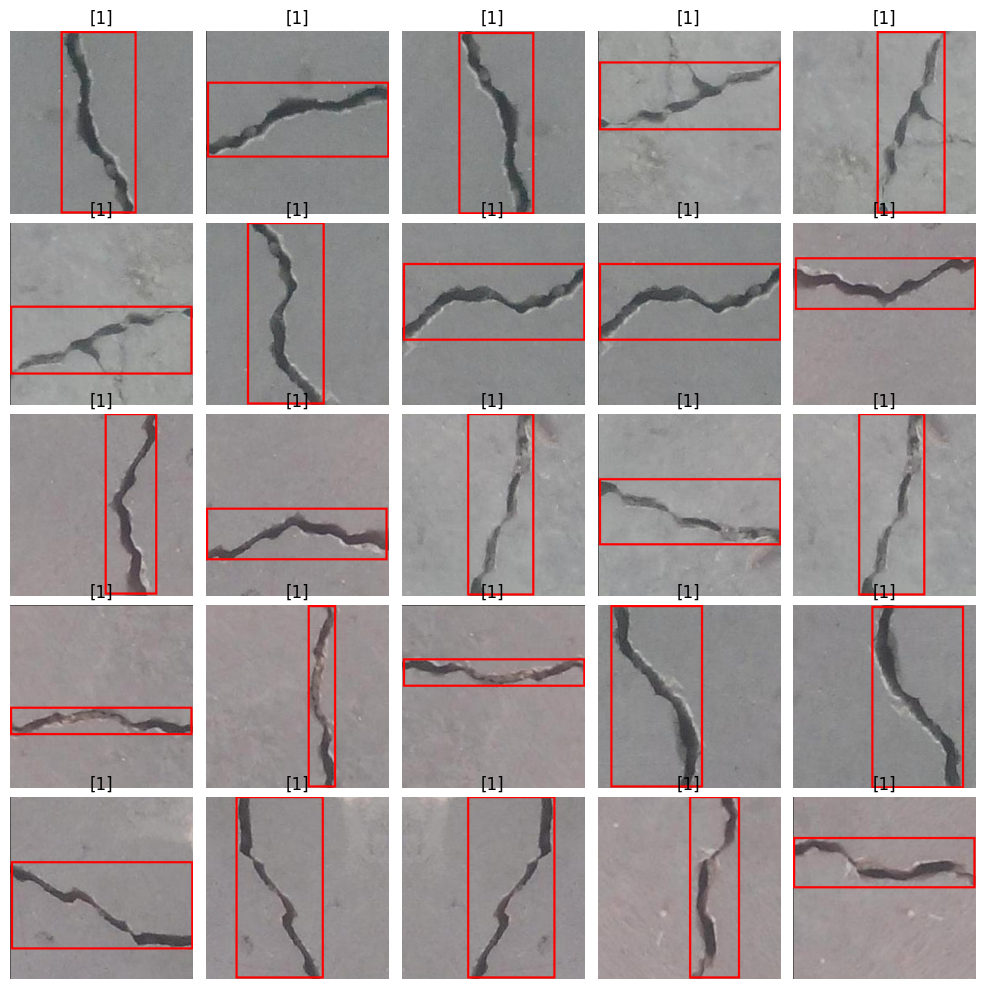

In [8]:
#데이터셋 시각화
#label=['crack', 'mold', 'peeling_paint', 'stairstep_crack', 'water_seepage']

#img=cv2.imread(img_list[1])
#img_size=img.shape

results=[]
fig = plt.figure(figsize=(10, 10))


for i in range(25):
    
    img_int = read_image(img_list[i])
    img_size=(img_int.permute(1,2,0)).shape
    boxes=read_boxes_from_file(txt_list[i])
    #print(boxes)
    get_boxes=[]
    get_labels=[]
    for box in boxes:
        label=box[0]
        box=box[1]
        box=list(get_xxyy(box, size=img_size))
        get_labels.append(label)
        get_boxes.append(box)
    get_boxes=torch.tensor(get_boxes, dtype=torch.float)
    #print(get_labels)
    colors = ["red"]*len(get_boxes)
    result = draw_bounding_boxes(img_int, get_boxes, colors=colors, width=5)
    results.append((result, get_labels)) #results : [(tensor pic, [label])]

for i, (image_tensor,label) in enumerate(results):
    # Convert the tensor to a NumPy array

    image_np = image_tensor.permute(1, 2, 0).numpy()
    
    # Create a subplot in the table
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_title(str(label))

plt.tight_layout()
# Adjust the spacing and layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Show the plot
plt.show()

## 하나의 이진 탐지 데이터셋으로 합치기
1. 각각 load 후에 concat 하는 방법
1. 하나의 파일로 몰아넣기

=> 2번 방식으로 진행

In [16]:
import os
import shutil

def copy_files(source_folder, destination_folder):
    # Get a list of all files in the source folder
    file_list = os.listdir(source_folder)

    # Iterate over each file and copy it to the destination folder
    for file_name in file_list:
        # Construct the full path of the source file
        source_file = os.path.join(source_folder, file_name)

        # Construct the full path of the destination file
        destination_file = os.path.join(destination_folder, file_name)

        # Copy the file to the destination folder
        shutil.copy(source_file, destination_file)

def move_files(source_folder, destination_folder):
    # Get a list of all files in the source folder
    file_list = os.listdir(source_folder)

    # Iterate over each file and move it to the destination folder
    for file_name in file_list:
        # Construct the full path of the source file
        source_file = os.path.join(source_folder, file_name)

        # Construct the full path of the destination file
        destination_file = os.path.join(destination_folder, file_name)

        # Move the file to the destination folder
        shutil.move(source_file, destination_file)


In [11]:
source_dir="./datasets/classification/UW"
destination_dir="./datasets/classification/Negative"

move_files(source_dir, destination_dir)

In [11]:
source_dir=glob.glob("./datasets/box/relabeled_8/*")
destination_folder="./datasets/box/rebuild_v2/"

for d in source_dir:
    if not os.path.isdir(d):
        continue
    for item in glob.glob(d+"/*"):
        #print(item)
        part=item.split("\\")[-2] # test train val
        file_cat=item.split("\\")[-1] # images or labels
        target=destination_folder+part+"/"+file_cat
        os.makedirs(target, exist_ok=True)
        copy_files(item,target)
                
    #print(part)
#os.makedirs(destination_folder, exist_ok=True)

In [54]:
source_dir=glob.glob("./datasets/box/relabeled_1/*")
destination_folder="./datasets/box/rebuild/"
part=glob.glob(dir+"/*")
# for d in source_dir:
#     if not os.path.isdir(d):
#         continue
for item in source_dir:
    #print(item)
    #part=item.split("\\")[-2] 
    file_cat=item.split("\\")[-1] # images or labels
    target=destination_folder+"/"+file_cat
    os.makedirs(target, exist_ok=True)
    #print(file_cat)
    #print(item)
    copy_files(item,target)

In [56]:
move_files("./datasets/box/rebuild/images/", "./datasets/box/rebuild/train/images/")

In [57]:
move_files("./datasets/box/rebuild/labels/", "./datasets/box/rebuild/train/labels/")

## 파일 체크

In [22]:
root_dir='./datasets/box/rebuild_v2/test/'
txt_list=glob.glob(root_dir+"labels/*.txt")
img_list=glob.glob(root_dir+"images/*.jpg")
txt_list.sort()
img_list.sort()
#img_list[0].split("\\")[-1][:-4]
for i in range(len(txt_list)):
    txt=txt_list[i].split("\\")[-1][:-4]
    img=img_list[i].split("\\")[-1][:-4]
    if(txt!=img):
        print(f"not same! txt: {txt}/ img:{img}")
    #else:print(f"txt: {txt}/ img:{img}")
        

## split dataset

In [36]:
import os
import shutil
import random

def split_dataset(root_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    img_dirs=glob.glob(root_dir+'/*')

    # Create train, val, and test directories

    

    for dir in img_dirs:
        imgs=glob.glob(dir+"/*")
        random.shuffle(imgs)
        tot=len(imgs)
        train_dset=imgs[:int(tot*train_ratio)]
        val_dset=imgs[int(tot*0.8):int(tot*(train_ratio+val_ratio))]
        test_dset=imgs[int(tot*(train_ratio+val_ratio)):]

        train_dir = os.path.join(dir, 'train')
        val_dir = os.path.join(dir, 'val')
        test_dir = os.path.join(dir, 'test')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        for i in range(len(train_dset)):
            #print(train_dset[i], train_dir+"/"+train_dset[i].split("\\")[-1])
            if os.isdir(train_dset[i]):
                continue
            shutil.move(train_dset[i], train_dir+"/"+train_dset[i].split("\\")[-1])

        for i in range(len(val_dset)):
            if os.isdir(val_dset[i]):
                continue
            shutil.move(val_dset[i], val_dir+"/"+val_dset[i].split("\\")[-1])
            
        for i in range(len(test_dset)):
            if os.isdir(test_dset[i]):
                continue
            shutil.move(test_dset[i], test_dir+"/"+test_dset[i].split("\\")[-1])
            
        #print(dir)
        #print(train_dir)
root_dir = "./datasets/classification/"
split_dataset(root_dir)


FileNotFoundError: [Errno 2] No such file or directory: './datasets/classification\\Negative\\val/7010-144.jpg'

In [14]:
import os
import shutil
import random
from glob import glob
from sklearn.model_selection import train_test_split

pos=glob("./datasets/classification/Positive/*.jpg")
neg=glob("./datasets/classification/Negative/*.jpg")
_,sub_pos=train_test_split(pos, test_size=0.04, random_state=42)
_,sub_neg=train_test_split(neg, test_size=0.04, random_state=42)
len(sub_neg) # 1170 , 1256 ,503




503

In [20]:
copy_files("./datasets/classification/new-tesis-5/train/images/", "./datasets/classification/sub_neg/")

In [19]:
cnt=0
for img in sub_pos:
    if not(os.path.isfile(img)):
        continue
    shutil.copy(img, os.path.join("./datasets/classification/sub_pos/", f'{cnt}.jpg'))
    cnt+=1

In [22]:
glob.glob("./datasets/classification/Negative/*")[0].split("\\")[-1]

'00001.jpg'

In [2]:
import os
import shutil
import random
from glob import glob



def random_copies(source_folder, destination_folder):
    file_list = os.listdir(source_folder)

    # Iterate over each file and copy it to the destination folder
    random_list=random.sample(file_list,100)
    for file_name in random_list:
        # Construct the full path of the source file
        source_file = os.path.join(source_folder, file_name)

        # Construct the full path of the destination file
        destination_file = os.path.join(destination_folder, file_name)

        # Copy the file to the destination folder
        shutil.copy(source_file, destination_file)

random_copies("./datasets/classification/sub_pos/", test_path)

In [4]:
import os
test_path='C:/Users/yj/OneDrive - UOS/바탕 화면/python workspace/intern_work/cv/datasets/test_set'

# List all files in the folder
file_list = os.listdir(test_path)

# Rename each file in the folder
for i, old_name in enumerate(file_list):
    if "neg" in old_name:
        continue 

    extension = os.path.splitext(old_name)[1]  # Get the file extension
    new_name = f"pos_{i + 1}{extension}"  # Create the new name based on the index
    old_path = os.path.join(test_path, old_name)
    new_path = os.path.join(test_path, new_name)

    os.rename(old_path, new_path)

print("All files have been renamed.")

All files have been renamed.


In [6]:
os.path.basename(new_path)

'pos_100.jpg'